# Bayesian Statistics for Physicists: 03 Choosing Priors

## Contents of the BSFP series

<ul>
    <li><a href="BSFP_01_Overview_and_setup.ipynb">01 Overview and Setup</a>
    <li><a href="BSFP_02_Basics.ipynb">02 Bayesian basics</a>
    <li><a href="BSFP_03_Choosing_priors.ipynb">03 Choosing priors</a>
    <li><a href="BSFP_04_Bayesian_updating.ipynb">04 Examples of Bayesian updating</a>
    <li><a href="BSFP_05_Sampling.ipynb">05 Sampling</a>
    <li><a href="BSFP_06_Model_selection_and_mixing.ipynb">06 Model selection, mixing, ...</a>
    <li><a href="BSFP_07_Gaussian_processes.ipynb">07 Gaussian processes</a>
    <li><a href="BSFP_08_Machine_learning.ipynb">08 Machine learning</a>
    <li><a href="BSFP_A01_Appendices.ipynb">A01 Appendices: reference, vocabulary, notation</a>
</ul>

<hr>

## <a name="Overview">Overview of Choosing priors</a>

A key feature of Bayesian statistics is the choice of the prior probability distribution.  We should incorporate all of the information we have, but no more. What are the options for choosing priors?  What are the subtleties?  Places to use an <em>informative prior:</em>

<ul>
  <li>your dataset is small, but there is related information available from other systems;
  <li>your model is very flexible but you want to prevent overfitting (so use priors that prefer
      values close to zero);
  <li>you want to stay away from particular regions of parameter space: maybe strictly unphysical such as
      negative cross sections or acausal, or maybe
      counter to well-motivated assumptions such as parameters are of order unity;
  <li>the posterior from a previous experiment can become a prior ==> Bayesian updating;
  <li>other examples??
</ul>

Last revised: 16-Apr-2019 by Dick Furnstahl [furnstahl.1@osu.edu].

## <a name="Contents">Contents of this notebook on Choosing priors</a> 

<ul>
    <li> <a href="#MaxEntropy">Maximum entropy</a>
    <li> <a href="#ConjPriors">Conjugate priors</a>
</ul>

<hr>

## <a name="Python">Python/Jupyter set up</a>

See <a href="BSFP_01_Overview_and_setup.ipynb">Part 01</a> for overall installation and setup.

In [1]:
# set up for plots in this notebook using matplotlib (there are other plotting choices)
%matplotlib inline   

In [10]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
plt.style.use('seaborn') # pretty matplotlib plots

import corner
import pymc3 as pm


In [11]:
# make font adjustments
#plt.rcParams['font.size'] = 12
#plt.rcParams['legend.fontsize'] = 'medium'
#plt.rcParams['figure.titlesize'] = 'medium'
plt.rcdefaults()  # revert to defaults for now

In [12]:
%%html  
<!-- Use html cell magic to add css styling -->
<style>
  em {
      color: red;
  }
  dd {
      margin-left: 15px;
  }
  .red{color: red}
  .blue{color: blue}
</style>

### <a name="Uniform">Subtlety with uniform prior</a>

An example from the 2016 workshop on [Bayesian Methods in Astronomy](https://github.com/jakevdp/BayesianAstronomy/blob/master/Index.ipynb) considers fitting a straight line $y = mx+b$ to noisy data. If you take the prior on the slope $m$ to be uniform (flat), thinking that this is non-informative, then look at this plot, which samples lines with uniformly distributed slopes:

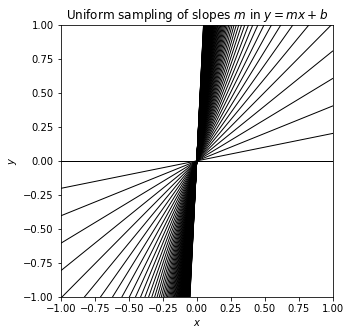

In [19]:
%matplotlib inline

x_pts = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.axis([-1., 1., -1., 1.])
for slope in np.linspace(0, 20, 100):   # 20 evenly spaced slopes m
    ax.plot(x_pts, slope * x_pts, '-k', linewidth=1)
ax.set_xlabel(r'$x$')    
ax.set_ylabel(r'$y$')    
ax.set_title(r'Uniform sampling of slopes $m$ in $y= mx + b$')
ax.set_aspect(1)


The density of the lines indicates the relative probability of different slopes. Summary point: flat priors are not necessarily minimally informative.  For the slope we probably want a prior that does not artificially over-weight large slopes; see http://arxiv.org/abs/1411.5018 for some discussion. For example, we might use a flat prior on the *angle* the line makes with the x-axis, which implies
$$
P(m) \propto (1 + m^2)^{-3/2}
$$

### <a name="MaxEnt">Maximum entropy for priors (appealing to physicists!)</a>

<ul>
 <li> Basic idea: identify least informative $p(x)$ from maximizing entropy:
   $$
     S[p(x)] = -\int\!dx\, p(x)\, \log\left[\frac{p(x)}{m(x)}\right]
   $$
   subject to constraints from the prior information.
   <ul>
      <li> $m(x)$ is an appropriate measure (often uniform, but see Sivia)
      <li> Use Lagrange multiplier(s) to maximize
   </ul>

 <li> One constraint is always normalization: $\int\!dx\, p(x) = 1$
     $\Longrightarrow$ alone it leads to uniform $p(x)$ (actually to $m(x)$)

 <li>
   If the mean $\mu$ and variance $\sigma^2$ are known, then maximize (may be clearer to do with discretized variables)
  
   \begin{align}
    Q[p(x)] &= -\int\! dx\, p(x)\, \log\left[\frac{p(x)}{m(x)}\right] 
    + \lambda_0 \left[ 1 - \int\! dx\, p(x) \right] \\
     & \quad + \lambda_1 \left[\sigma^2 -  \int\! dx\, (x-\mu)^2 p(x)  \right]
   \end{align}
   
   Then
   $$    
    \frac{\delta Q}{\delta p(x)} = 0   \quad\mbox{and}\quad
     m(x) = \mbox{const.}
     \ \Longrightarrow\ 
     p(x \mid \mu,\sigma) = \frac{1}{\sigma\sqrt{2 \pi}} 
     e^{-(x-\mu)^2/2\sigma^2}    
   $$
   
  <li>
    For $\textbf{x} = \{x_1, \cdots, x_N\}$, we find $p(\textbf{x})$
    is the familiar least-squares likelihood function.  See Sivia for many more details.




If you want a "scale invariant" prior, this often means a flat prior on the *logarithm* of the parameter.  This is an example of a [Jeffreys Prior](https://en.wikipedia.org/wiki/Jeffreys_prior).


<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>

### <a name="ConjPriors">Conjugate priors</a>

Bayes theorem tells us that the posterior follows from multiplying the prior by the likelihood and normalizing:  

$$ 
  p(\theta\,|\,x) = \frac{p(x\,|\,\theta)\, p(\theta)}
                          {\int\!d\theta'\, p(x\,|\,\theta')\, p(\theta')}
$$ 

If the resulting $p(\theta\,|\,x)$ is in the same family of pdfs as $p(\theta)$, then $p(\theta)$ is said to be a conjugate prior for the likelihood $p(x\,|\,\theta)$. 

The likelihood is often a fixed form. <em>If there is freedom to choose a conjugate prior, the Bayesian updating of the posterior is given in closed form.</em>  

Comments:
 <ul>
    <li>Suppose we are flipping a coin and seek the posterior for the probability of heads $\theta \in [0,1]$.  Let $x$ be the number of successes (heads) in $N$ trials. The likelihood is binomial: 
   $$ p(x\mid\theta) = \binom{N}{x} 
       \theta^{x} (1-\theta)^{N-x} \;. 
   $$
If we choose the prior to be a <i>beta distribution</i> with <em>hyperparameters</em> $a$ and $b$ (which are parameters of the prior as opposed to the model),  
   $$ p(\theta\mid a,b) = \textrm{Beta}(\theta\mid a,b)
      = \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)}
   $$
with beta function $B(a,b)$, then the posterior is of the same form ($\bar x \equiv N - x$):
   $$ p(\theta\mid x,a,b) = \frac{\theta^{x+a-1}(1-\theta)^{\bar x+b-1}}{B(x+a,\bar x+b)} = \textrm{Beta}(\theta\mid x+a,\bar x +b)
   $$                                 
This posterior can be used as the prior for more samples; the hyperparameters just add additional information (check that it doesn't matter if you analyze the data all at once or sequentially because the tosses are independent).
  <li>See the [Wikipedia article](https://en.wikipedia.org/wiki/Conjugate_prior) for a big table of conjugate prior pairs.
  <li>If the likelihood is a normal distribution with known variance, the conjugate prior is also normal.  If it is a normal distribution with known mean, the inverse gamma distribution is a conjugate prior.
 </ul>

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>